In [1]:
import time

# Record the start time
start_time = time.time()

In [2]:
import os
import pandas as pd
import numpy as np
from functools import partial

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import matplotlib.pyplot as plt

In [3]:
# The directory path

dir_path = r"data\SB01-SF01_OHL_60s_3mGrid_TS0\RAW_DATA"
#dir_path = r"data\PSH01-SF01_CDF_60s_2mGrid_TS0\RAW_DATA"
#dir_path = r"data\SKW01-SF01_CDF_150s_5mGrid_TS0\RAW_DATA"


# Get the parent directory of dir_path
parent_dir = os.path.dirname(os.path.normpath(dir_path))

# Extract the folder name from the parent directory
folder_name = os.path.basename(parent_dir)

# Construct the file paths
node_csv_path = os.path.join(dir_path, f"{folder_name}_nodes.csv")
shell_csv_path = os.path.join(dir_path, f"{folder_name}_shells.csv")
solid_csv_path = os.path.join(dir_path, f"{folder_name}_solids.csv")
nodal_vels_csv_path = os.path.join(dir_path, f"{folder_name}_nodal_velocities.csv")
solid_thickness_csv_path = os.path.join(dir_path, f"{folder_name}_solid_thicknesses.csv")
state_csv_path = os.path.join(dir_path, f"{folder_name}_states.csv")

# Functions

In [4]:
def calculate_nodal_statistics(element_df, node_df, node_columns, stat_columns, stat_func):
    # Create a DataFrame to hold the extracted node values
    extracted_node_values = pd.DataFrame(index=element_df.index)

    # Extract the node values for all specified columns
    for node_col in node_columns:
        # Map the node labels to the corresponding node values in node_df
        # This creates a temporary DataFrame of the node values
        temp_df = element_df[node_col].map(node_df[stat_columns].to_dict(orient='index'))
        
        # Convert the temporary DataFrame into a proper DataFrame and concatenate to the extracted values
        extracted_node_values = pd.concat([extracted_node_values, pd.DataFrame(list(temp_df.values), index=temp_df.index)], axis=1)

    # Now have a DataFrame where each group of 'stat_columns' for the nodes are in separate columns
    # Need to reshape this so can apply the stat_func across the correct axis
    num_nodes = len(node_columns)
    num_statistics = len(stat_columns)
    
    # Reshape the DataFrame so each row contains all node values for one element
    # This is done by treating the first num_statistics columns as one block, the next num_statistics as another, and so on
    reshaped_values = extracted_node_values.values.reshape(-1, num_nodes, num_statistics)
    
    # Calculate the statistic across the nodes for each element (across axis=1)
    statistics = stat_func(reshaped_values, axis=1)
    
    # Return the results as a numpy array
    return statistics


def print_unique_values_with_counts(df, column_name):
    """
    Prints the unique values and their counts for a specified column in a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the column of interest.
    column_name (str): The name of the column in the DataFrame for which to print the unique values and counts.

    Returns:
    None
    """
    if column_name in df.columns:
        unique_values = df[column_name].value_counts()
        print(f"Unique values and counts for column '{column_name}':")
        print(unique_values)
    else:
        print(f"The column '{column_name}' does not exist in the DataFrame.")

# Example usage:
# Assuming 'dataframe' is your pandas DataFrame and 'column_name' is the column you want to analyze.
# print_unique_values_with_counts(dataframe, 'column_name')

In [5]:
# Define some convertors for data preprocessing on import

# Define a generic converter function that rounds values to n decimal places
def round_to_n_decimals(x, n):
    return round(float(x), n)

# Rounding for X,Y,Z to 2 dcimal places
# Create a dictionary with the rounding function partially applied for each column
xyz_round_converter = {col_name: partial(round_to_n_decimals, n=2) for col_name in ['Node_X', 'Node_Y', 'Node_Z']}

# Nodal Velocity Converter

# There are 100s of states, to round the nodal velocities for all of them needs a different approach.
# Exclude from rounding
nodal_vels_exclude_cols = ['Node_Label']

# Read column names from the CSV file without reading the entire file
with open(nodal_vels_csv_path, 'r') as file:
    nodal_vels_headers = file.readline().strip().split(',')

# Create a dictionary with the rounding function partially applied for each column
# Exclude the specified column
nodal_vels_converter = {col_name: partial(round_to_n_decimals, n=2) for col_name in nodal_vels_headers if col_name not in nodal_vels_exclude_cols}


# Solid Thickness Converter

# Exclude from rounding
solid_thick_exclude_cols = ['Solid_Label']

# Read column names from the CSV file without reading the entire file
with open(solid_thickness_csv_path, 'r') as file:
    solid_thick_headers = file.readline().strip().split(',')

solid_thick_converter = {col_name: partial(round_to_n_decimals, n=2) for col_name in solid_thick_headers if col_name not in solid_thick_exclude_cols}


In [6]:
nodes_cols = ['Node_Label', 'Node_X', 'Node_Y', 'Node_Z']
shell_cols = ['Shell_Label', 'Shell_Part', 'Shell_N1', 'Shell_N2', 'Shell_N3', 'Shell_N4']
solid_cols = ['Solid_Label', 'Solid_Part', 'Solid_N1', 'Solid_N2', 'Solid_N3', 'Solid_N4', 'Solid_N5', 'Solid_N6', 'Solid_N7', 'Solid_N8']

In [7]:
# Load the CSV files into pandas DataFrames
nodes_df = pd.read_csv(node_csv_path, converters=xyz_round_converter, usecols=nodes_cols)
shells_df = pd.read_csv(shell_csv_path, usecols=shell_cols)
solids_df = pd.read_csv(solid_csv_path, usecols=solid_cols)
nodal_vels_df = pd.read_csv(nodal_vels_csv_path, converters=nodal_vels_converter)
solids_thick_df = pd.read_csv(solid_thickness_csv_path, converters=solid_thick_converter)

# Set Node_Label as the index of  easier lookup
nodes_df.set_index('Node_Label', inplace=True)
nodal_vels_df.set_index('Node_Label', inplace=True)

# Get center points of solids and shells

In [8]:
# Calculate the mean X, Y, and Z (center point) for each shell element
shell_centre_points = calculate_nodal_statistics(
    element_df=shells_df,
    node_df=nodes_df,
    node_columns=['Shell_N1', 'Shell_N2', 'Shell_N3', 'Shell_N4'],
    stat_columns=['Node_X', 'Node_Y', 'Node_Z'],
    stat_func=np.mean
)

# Split the mean_positions array into separate columns and add to shell_df
shells_df[['Shell_X','Shell_Y', 'Shell_Z']] = shell_centre_points



In [9]:
# Get topo only

filtered_shells_df = shells_df[shells_df['Shell_Part'] == 1]

topo_shells_df = filtered_shells_df[['Shell_Label', 'Shell_X', 'Shell_Y', 'Shell_Z']].copy()

topo_shells_df['Group_ID'] = topo_shells_df['Shell_X'].astype(str) + '_' + topo_shells_df['Shell_Y'].astype(str)

topo_shells_df

,Shell_Label,Shell_X,Shell_Y,Shell_Z,Group_ID
0,1,819352.0,826661.0,52.2150,819352.0_826661.0
1,2,819354.0,826661.0,53.1025,819354.0_826661.0
2,3,819356.0,826661.0,54.0125,819356.0_826661.0
3,4,819358.0,826661.0,54.7050,819358.0_826661.0
4,5,819360.0,826661.0,55.1275,819360.0_826661.0
...,...,...,...,...,...
14394,14395,819584.0,826897.0,51.1700,819584.0_826897.0
14395,14396,819586.0,826897.0,52.9700,819586.0_826897.0
14396,14397,819588.0,826897.0,54.6525,819588.0_826897.0
14397,14398,819590.0,826897.0,56.0800,819590.0_826897.0


In [10]:
# Calculate the mean X, Y, and Z (center point) for each shell element
solid_centre_points = calculate_nodal_statistics(
    element_df=solids_df,
    node_df=nodes_df,
    node_columns=['Solid_N1', 'Solid_N2', 'Solid_N3', 'Solid_N4', 'Solid_N5', 'Solid_N6', 'Solid_N7', 'Solid_N8'],
    stat_columns=['Node_X', 'Node_Y', 'Node_Z'],
    stat_func=np.mean
)

# Split the mean_positions array into separate columns and add to solids_df
solids_df[['Solid_X', 'Solid_Y', 'Solid_Z']] = solid_centre_points

solids_df

,Solid_Label,Solid_Part,Solid_N1,Solid_N2,Solid_N3,Solid_N4,Solid_N5,Solid_N6,Solid_N7,Solid_N8,Solid_X,Solid_Y,Solid_Z
0,1,5,14641,14642,14653,14652,17763,17764,17775,17774,819506.0,826709.0,45.2250
1,2,5,14642,14643,14654,14653,17764,17765,17776,17775,819508.0,826709.0,45.7725
2,3,5,14643,14644,14655,14654,17765,17766,17777,17776,819510.0,826709.0,46.7450
3,4,5,14644,14645,14656,14655,17766,17767,17778,17777,819512.0,826709.0,47.6850
4,5,5,14645,14646,14657,14656,17767,17768,17779,17778,819514.0,826709.0,48.3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62449,62450,5,80170,80171,80198,80197,83292,83293,83320,83319,819472.0,826849.0,27.3375
62450,62451,5,80171,80172,80199,80198,83293,83294,83321,83320,819474.0,826849.0,28.0100
62451,62452,5,80172,80173,80200,80199,83294,83295,83322,83321,819476.0,826849.0,28.7650
62452,62453,5,80173,80174,80201,80200,83295,83296,83323,83322,819478.0,826849.0,29.3950


# Calculate Nodal Velocity per Solid Element

In [11]:
solids_df

,Solid_Label,Solid_Part,Solid_N1,Solid_N2,Solid_N3,Solid_N4,Solid_N5,Solid_N6,Solid_N7,Solid_N8,Solid_X,Solid_Y,Solid_Z
0,1,5,14641,14642,14653,14652,17763,17764,17775,17774,819506.0,826709.0,45.2250
1,2,5,14642,14643,14654,14653,17764,17765,17776,17775,819508.0,826709.0,45.7725
2,3,5,14643,14644,14655,14654,17765,17766,17777,17776,819510.0,826709.0,46.7450
3,4,5,14644,14645,14656,14655,17766,17767,17778,17777,819512.0,826709.0,47.6850
4,5,5,14645,14646,14657,14656,17767,17768,17779,17778,819514.0,826709.0,48.3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62449,62450,5,80170,80171,80198,80197,83292,83293,83320,83319,819472.0,826849.0,27.3375
62450,62451,5,80171,80172,80199,80198,83293,83294,83321,83320,819474.0,826849.0,28.0100
62451,62452,5,80172,80173,80200,80199,83294,83295,83322,83321,819476.0,826849.0,28.7650
62452,62453,5,80173,80174,80201,80200,83295,83296,83323,83322,819478.0,826849.0,29.3950


In [12]:
# Assuming your node_vels_df contains columns for each timestep
# and that all columns except 'Node_Label' are timesteps
timestep_columns = [col for col in nodal_vels_df.columns if col != 'Node_Label']

# Now call the function with the dynamically generated list of timestep columns
max_nodal_velocities = calculate_nodal_statistics(
    element_df=solids_df,
    node_df=nodal_vels_df,
    node_columns=['Solid_N1', 'Solid_N2', 'Solid_N3', 'Solid_N4', 'Solid_N5', 'Solid_N6', 'Solid_N7', 'Solid_N8'],
    stat_columns=timestep_columns,
    stat_func=np.max
)

# Assuming max_nodal_velocities is a numpy array with the correct shape
# Create a dictionary where each key-value pair is a column name and the corresponding max velocities
max_velocity_dict = {col: max_nodal_velocities[:, i] for i, col in enumerate(timestep_columns)}

# Convert the dictionary to a DataFrame
max_velocity_df = pd.DataFrame(max_velocity_dict)

# Concatenate this DataFrame with solids_df
solids_vels_df = pd.concat([solids_df[['Solid_Label']], max_velocity_df], axis=1)



# AT THIS POINT - I HAVE THE VELOCITY PER SOLIDS, BASED ON THE MAX VELOCITY RECORDED BY ANY OF ITS NODES.






# Group the solids that have the same XY, again taking the max velocity in the "stack" of solids.

In [13]:
# Merge 'Solid_X' and 'Solid_Y' into solids_vels_df based on 'Solid_ID'
solids_vels_df = solids_vels_df.merge(solids_df[['Solid_Label', 'Solid_X', 'Solid_Y']], on='Solid_Label', how='left')

# Now create the Group_ID based on 'Solid_X' and 'Solid_Y'
solids_vels_df['Group_ID'] = solids_vels_df['Solid_X'].astype(str) + '_' + solids_vels_df['Solid_Y'].astype(str)


# Assuming `df` is your dataframe
# Drop the 'Solid_Label' column as it's not needed
solids_vels_df = solids_vels_df.drop('Solid_Label', axis=1)

# Define the aggregation dictionary for columns. 'max' for maximum, 'first' for taking the first value (we won't aggregate 'Solid_X' and 'Solid_Y')
agg_funcs = {col: 'max' for col in solids_vels_df.columns if col not in ['Solid_X', 'Solid_Y', 'Group_ID']}
agg_funcs['Solid_X'] = 'first'  # Presuming you want to keep the first 'Solid_X' value for each group
agg_funcs['Solid_Y'] = 'first'  # Presuming you want to keep the first 'Solid_Y' value for each group

# Group by 'Group_ID' and aggregate using the agg_funcs dictionary
solids_vels_df = solids_vels_df.groupby('Group_ID').agg(agg_funcs).reset_index()


# Reorder columns to move 'Solid_X' and 'Solid_Y' to the second and third positions
cols = ['Group_ID', 'Solid_X', 'Solid_Y'] + [col for col in solids_vels_df.columns if col not in ['Group_ID', 'Solid_X', 'Solid_Y']]
solids_vels_df = solids_vels_df[cols]

In [14]:
solids_thick_df

,Solid_Label,State_1,State_2,State_3,State_4,State_5,State_6,State_7,State_8,State_9,...,State_110,State_111,State_112,State_113,State_114,State_115,State_116,State_117,State_118,State_119
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62449,62450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62450,62451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62451,62452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62452,62453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# For thickness, I already have the thickness per solid, but need to group those that have the same XY, taking the mass addition of all the thicnkess in the stack of solids

In [15]:
# Merge 'Solid_X' and 'Solid_Y' into solids_thick_df based on 'Solid_ID'
solids_thick_df = solids_thick_df.merge(solids_df[['Solid_Label', 'Solid_X', 'Solid_Y']], on='Solid_Label', how='left')

# Now create the Group_ID based on 'Solid_X' and 'Solid_Y'
solids_thick_df['Group_ID'] = solids_thick_df['Solid_X'].astype(str) + '_' + solids_thick_df['Solid_Y'].astype(str)


# Assuming `df` is your dataframe
# Drop the 'Solid_Label' column as it's not needed
solids_thick_df = solids_thick_df.drop('Solid_Label', axis=1)

# Define the aggregation dictionary for columns. 'max' for maximum, 'first' for taking the first value (we won't aggregate 'Solid_X' and 'Solid_Y')
agg_funcs = {col: 'sum' for col in solids_thick_df.columns if col not in ['Solid_X', 'Solid_Y', 'Group_ID']}
agg_funcs['Solid_X'] = 'first'  # Presuming you want to keep the first 'Solid_X' value for each group
agg_funcs['Solid_Y'] = 'first'  # Presuming you want to keep the first 'Solid_Y' value for each group

# Group by 'Group_ID' and aggregate using the agg_funcs dictionary
solids_thick_df = solids_thick_df.groupby('Group_ID').agg(agg_funcs).reset_index()


# Reorder columns to move 'Solid_X' and 'Solid_Y' to the second and third positions
cols = ['Group_ID', 'Solid_X', 'Solid_Y'] + [col for col in solids_thick_df.columns if col not in ['Group_ID', 'Solid_X', 'Solid_Y']]
solids_thick_df = solids_thick_df[cols]

In [16]:
solids_vels_df

,Group_ID,Solid_X,Solid_Y,State_1,State_2,State_3,State_4,State_5,State_6,State_7,...,State_110,State_111,State_112,State_113,State_114,State_115,State_116,State_117,State_118,State_119
0,819402.0_826793.0,819402.0,826793.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,819402.0_826795.0,819402.0,826795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,819402.0_826797.0,819402.0,826797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,819402.0_826799.0,819402.0,826799.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,819402.0_826801.0,819402.0,826801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,819544.0_826747.0,819544.0,826747.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2970,819544.0_826749.0,819544.0,826749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2971,819544.0_826751.0,819544.0,826751.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2972,819544.0_826753.0,819544.0,826753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
solids_thick_df

,Group_ID,Solid_X,Solid_Y,State_1,State_2,State_3,State_4,State_5,State_6,State_7,...,State_110,State_111,State_112,State_113,State_114,State_115,State_116,State_117,State_118,State_119
0,819402.0_826793.0,819402.0,826793.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,819402.0_826795.0,819402.0,826795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,819402.0_826797.0,819402.0,826797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,819402.0_826799.0,819402.0,826799.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,819402.0_826801.0,819402.0,826801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,819544.0_826747.0,819544.0,826747.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2970,819544.0_826749.0,819544.0,826749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2971,819544.0_826751.0,819544.0,826751.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2972,819544.0_826753.0,819544.0,826753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
def pad_results_to_match_topo(topo_df, results_df, group_id_col='Group_ID', fill_value=0):
    """
    Merge the topo DataFrame with the results DataFrame using the 'Group_ID' column.
    This will include all entries from topo_df, padding the results_df to the same extent.
    Missing 'Solid_X' and 'Solid_Y' values in results_df will be filled with the
    corresponding 'Shell_X' and 'Shell_Y' values from topo_df. State columns will be filled with
    the specified fill value. After the merge, all columns from topo_df, except for 'Group_ID',
    will be removed from the resulting DataFrame.

    Args:
    topo_df (pd.DataFrame): DataFrame containing the topography data with 'Shell_X', 'Shell_Y', and 'Group_ID'.
    results_df (pd.DataFrame): DataFrame containing the results data with 'Solid_X', 'Solid_Y', 'Group_ID', and state columns.
    group_id_col (str): Column name for the group ID used to merge the DataFrames.
    fill_value (int, float): The value to fill in for missing state data.

    Returns:
    pd.DataFrame: DataFrame with topography information merged and padded onto the results DataFrame.
    """
    # Merge the topography and results DataFrame on the Group_ID column with an outer join
    merged_df = pd.merge(topo_df, results_df, how='outer', on=group_id_col)

    # Fill NaN values for 'Solid_X' and 'Solid_Y' in the results data
    # with the corresponding 'Shell_X' and 'Shell_Y' values from the topo data
    merged_df['Solid_X'] = merged_df['Solid_X'].fillna(merged_df['Shell_X'])
    merged_df['Solid_Y'] = merged_df['Solid_Y'].fillna(merged_df['Shell_Y'])

    # Fill NaN values in the state columns with the specified fill value
    state_cols = [col for col in merged_df.columns if col.startswith('State_')]
    merged_df[state_cols] = merged_df[state_cols].fillna(fill_value)

    # Drop the shell-related columns from the merged DataFrame
    shell_cols = ['Shell_Label', 'Shell_X', 'Shell_Y', 'Shell_Z']
    merged_df.drop(columns=shell_cols, inplace=True)

    return merged_df

# Usage example:
# merged_df = merge_and_pad_topo_with_results(topo_df, results_df, fill_value=0)

# Usage example:
# merged_df = merge_topo_with_results(topo_df, results_df, fill_value=0)

# Usage example:
# padded_results_df = pad_results_to_match_topo(topo_shells_df, results_df, fill_value=0)



def dataframe_to_elevation_array(df, x_col='Solid_X', y_col='Solid_Y', z_col='Elevation'):
    """
    Convert a DataFrame with positions and elevation values into a 2D NumPy array.

    Args:
    df (pd.DataFrame): Input DataFrame with positions and elevation values.
    x_col (str): Name of the column representing the X position.
    y_col (str): Name of the column representing the Y position.
    z_col (str): Name of the column representing the elevation value.

    Returns:
    tuple: A tuple containing:
           - np.ndarray: 2D NumPy array of elevation values.
           - np.ndarray: Array of unique X coordinates.
           - np.ndarray: Array of unique Y coordinates.
    """
    # Get unique X and Y positions
    unique_x = np.sort(df[x_col].unique())
    unique_y = np.sort(df[y_col].unique())

    # Create a mapping from position value to index
    x_positions = {x: i for i, x in enumerate(unique_x)}
    y_positions = {y: i for i, y in enumerate(unique_y)}

    # Initialize the elevation array
    elevation_array = np.zeros((len(unique_y), len(unique_x)))

    # Fill the elevation array with the corresponding values from the DataFrame
    for _, row in df.iterrows():
        x_idx = x_positions[row[x_col]]
        y_idx = y_positions[row[y_col]]
        elevation_array[y_idx, x_idx] = row[z_col]

    return elevation_array, unique_x, unique_y


def dataframe_to_state_arrays(df, x_col, y_col, state_cols_prefix='State_'):
    """
    Convert a DataFrame with positions and state values into a series of 2D NumPy arrays,
    return the unique X and Y coordinates, and the state labels as well.

    Args:
        df (pd.DataFrame): Input DataFrame with positions and state values.
        x_col (str): Name of the column representing the X position.
        y_col (str): Name of the column representing the Y position.
        state_cols_prefix (str): Prefix of the columns representing state values.

    Returns:
        tuple: A tuple containing:
               - List[np.ndarray]: List of 2D NumPy arrays for each state.
               - List[str]: List of labels for each state array.
               - np.ndarray: Array of unique X coordinates.
               - np.ndarray: Array of unique Y coordinates.
    """
    # Get unique X and Y positions
    unique_x = np.sort(df[x_col].unique())
    unique_y = np.sort(df[y_col].unique())

    # Create a mapping from position value to index
    x_positions = {x: i for i, x in enumerate(unique_x)}
    y_positions = {y: i for i, y in enumerate(unique_y)}

    # Get the state columns and their labels
    state_cols = [col for col in df.columns if col.startswith(state_cols_prefix)]
    state_labels = [col.replace(state_cols_prefix, '') for col in state_cols]

    # Initialize a list to hold the state arrays
    state_arrays = [np.zeros((len(unique_y), len(unique_x))) for _ in state_cols]

    # Fill the state arrays with the corresponding values from the DataFrame
    for _, row in df.iterrows():
        x_idx = x_positions[row[x_col]]
        y_idx = y_positions[row[y_col]]
        for i, state_col in enumerate(state_cols):
            state_arrays[i][y_idx, x_idx] = row[state_col]

    return state_arrays, state_labels, unique_x, unique_y


def array_to_raster_image(array, colormap='viridis', output_file='raster_image.png'):
    """
    Convert a NumPy array to a raster image, colored by a scale.

    Args:
    array (np.ndarray): 2D NumPy array to convert to a raster image.
    colormap (str): Name of the colormap to use.
    output_file (str): Path to save the output raster image file.

    Returns:
    None
    """
    # Normalize the array values to the range [0, 1]
    norm = Normalize(vmin=array.min(), vmax=array.max())

    # Create a figure and axis to plot the image
    fig, ax = plt.subplots()
    # Plot the array with the given colormap
    cax = ax.imshow(array, cmap=colormap, norm=norm)
    # Remove the axis for a cleaner look
    ax.axis('off')
    # Add a colorbar to the image to show the scale
    fig.colorbar(cax)
    # Save the image to the specified file
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    # Close the figure to free up memory
    plt.close(fig)



def plot_array_as_raster(array, x_coords, y_coords, colormap='viridis', show_coords=True, blank_zeros=True):
    """
    Plot a 2D NumPy array as a raster image with an option to show or hide XY coordinates on the axis,
    and an option to mask zero values so they appear white.

    Args:
    array (np.ndarray): The 2D NumPy array to plot.
    x_coords (np.ndarray): Array of X coordinates.
    y_coords (np.ndarray): Array of Y coordinates.
    colormap (str): Colormap to use for plotting.
    show_coords (bool): Flag to determine whether to show XY coordinates on the axis.
    blank_zeros (bool): Flag to determine whether to mask zero values.

    Returns:
    None
    """
    # Optionally create a masked array where zeros are masked
    plot_array = np.ma.masked_where(array == 0, array) if blank_zeros else array

    # Normalize the colormap based on the non-masked data
    norm = Normalize(vmin=plot_array.min(), vmax=plot_array.max())

    # Plotting
    fig, ax = plt.subplots()
    cax = ax.imshow(plot_array, cmap=colormap, norm=norm, 
                    extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()] if show_coords else None)

    # Set axis labels
    if show_coords:
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        plt.xticks(rotation=45)
    else:
        ax.set_xticks([])
        ax.set_yticks([])

    # Create colorbar
    fig.colorbar(cax, ax=ax)

    plt.show()

def plot_state_arrays_range(state_arrays, x_coords, y_coords, start_state, end_state, colormap='viridis', show_coords=True):
    """
    Plot a range of state arrays as raster images with an option to show or hide XY coordinates on the axis.

    Args:
    state_arrays (List[np.ndarray]): List of 2D NumPy arrays for each state.
    x_coords (np.ndarray): Array of unique X coordinates.
    y_coords (np.ndarray): Array of unique Y coordinates.
    start_state (int): The starting index of the state to plot.
    end_state (int): The ending index of the state to plot (inclusive).
    colormap (str): Colormap to use for plotting.
    show_coords (bool): Flag to determine whether to show XY coordinates on the axis.

    Returns:
    None
    """
    for i in range(start_state, end_state + 1):
        print(f"Plotting State {i}")
        plot_array_as_raster(state_arrays[i], x_coords, y_coords, colormap, show_coords)

def flatten_to_max_value(state_arrays):
    """
    Flatten a list of 2D state arrays into a single array, keeping the maximum value at any location.

    Args:
    state_arrays (List[np.ndarray]): List of 2D NumPy arrays representing different states.

    Returns:
    np.ndarray: A 2D NumPy array with the maximum value at each location.
    """
    # Stack the arrays along a new dimension and then take the max along this new dimension
    max_value_array = np.max(np.stack(state_arrays), axis=0)

    return max_value_array

def save_individual_array_to_npy(array, label, model_id, directory='.'):
    """
    Save an individual state array to a `.npy` file with the model ID and specified label.

    Args:
        array (np.ndarray): The 2D NumPy array to be saved.
        label (str): The label for the array.
        model_id (str): Identifier for the model.
        directory (str): The directory to save the file in. Defaults to the current directory.
    """
    # Ensure the output directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the array to a `.npy` file
    file_name = f"{model_id}_{label}.npy"
    file_path = os.path.join(directory, file_name)
    np.save(file_path, array)
    print(f"Saved {file_name} to {directory}")

def save_state_arrays_to_npy(state_arrays, state_labels, model_id, directory='.'):
    """
    Save a list of state arrays to `.npy` files with the state label as part of the file name.

    Args:
        state_arrays (List[np.ndarray]): List of 2D NumPy arrays for each state.
        state_labels (List[str]): List of labels for each state array.
        model_id (str): Identifier for the model.
        directory (str): The directory to save the files in. Defaults to the current directory.

    Raises:
        ValueError: If the lengths of state_arrays and state_labels do not match.
    """
    if len(state_arrays) != len(state_labels):
        raise ValueError("The lengths of state_arrays and state_labels must match.")

    # Ensure the output directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save each state array to a separate `.npy` file
    for array, label in zip(state_arrays, state_labels):
        file_name = f"{model_id}_{label}.npy"
        file_path = os.path.join(directory, file_name)
        np.save(file_path, array)
        print(f"Saved {file_name} to {directory}")



In [19]:
print(len(topo_shells_df))

14399


In [20]:
print(len(solids_thick_df))

2974


In [21]:
topo_shells_df

,Shell_Label,Shell_X,Shell_Y,Shell_Z,Group_ID
0,1,819352.0,826661.0,52.2150,819352.0_826661.0
1,2,819354.0,826661.0,53.1025,819354.0_826661.0
2,3,819356.0,826661.0,54.0125,819356.0_826661.0
3,4,819358.0,826661.0,54.7050,819358.0_826661.0
4,5,819360.0,826661.0,55.1275,819360.0_826661.0
...,...,...,...,...,...
14394,14395,819584.0,826897.0,51.1700,819584.0_826897.0
14395,14396,819586.0,826897.0,52.9700,819586.0_826897.0
14396,14397,819588.0,826897.0,54.6525,819588.0_826897.0
14397,14398,819590.0,826897.0,56.0800,819590.0_826897.0


In [22]:
temp_df = pad_results_to_match_topo(topo_shells_df, solids_vels_df)

In [23]:
print(len(temp_df))

14399


In [24]:
temp_df

,Group_ID,Solid_X,Solid_Y,State_1,State_2,State_3,State_4,State_5,State_6,State_7,...,State_110,State_111,State_112,State_113,State_114,State_115,State_116,State_117,State_118,State_119
0,819352.0_826661.0,819352.0,826661.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,819352.0_826663.0,819352.0,826663.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,819352.0_826665.0,819352.0,826665.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,819352.0_826667.0,819352.0,826667.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,819352.0_826669.0,819352.0,826669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14394,819592.0_826889.0,819592.0,826889.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14395,819592.0_826891.0,819592.0,826891.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14396,819592.0_826893.0,819592.0,826893.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14397,819592.0_826895.0,819592.0,826895.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
state_arrays, x_coords, y_coords = dataframe_to_state_arrays(solids_vels_df, x_col='Solid_X', y_col='Solid_Y')

ValueError: too many values to unpack (expected 3)

Plotting State 40


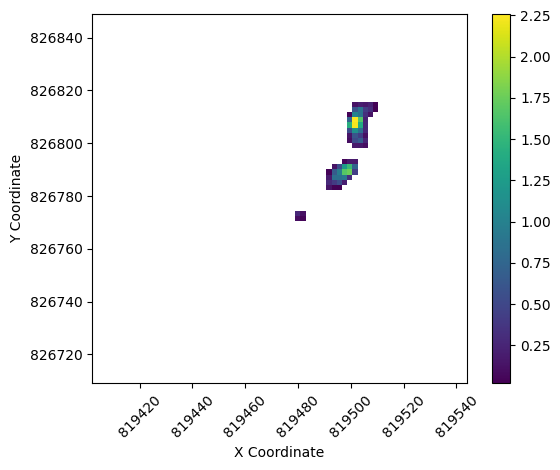

Plotting State 41


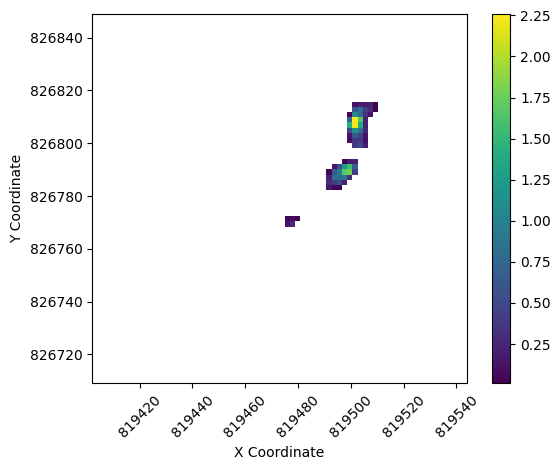

Plotting State 42


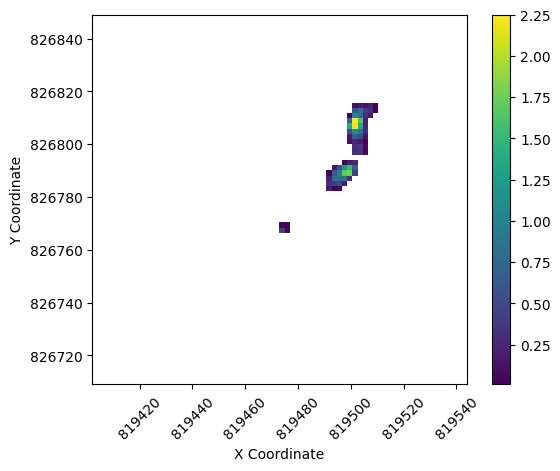

Plotting State 43


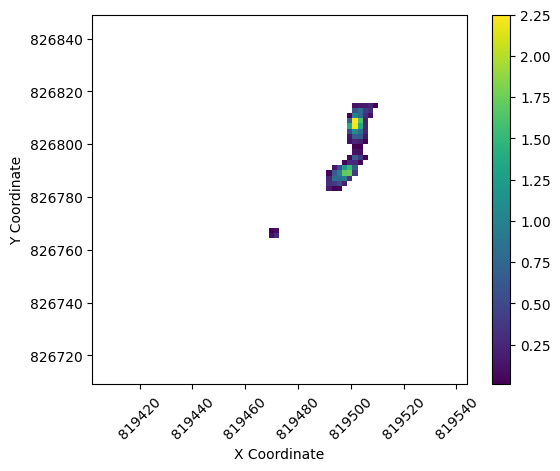

Plotting State 44


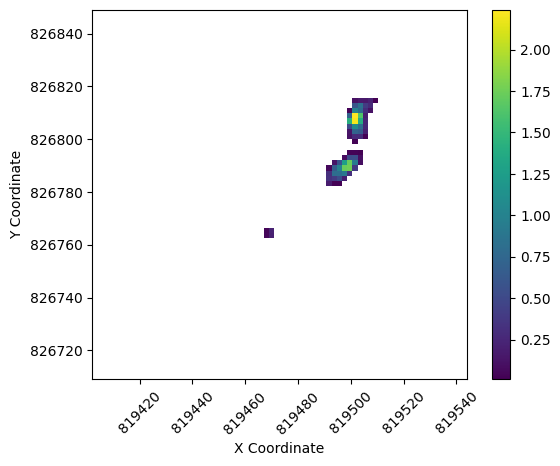

Plotting State 45


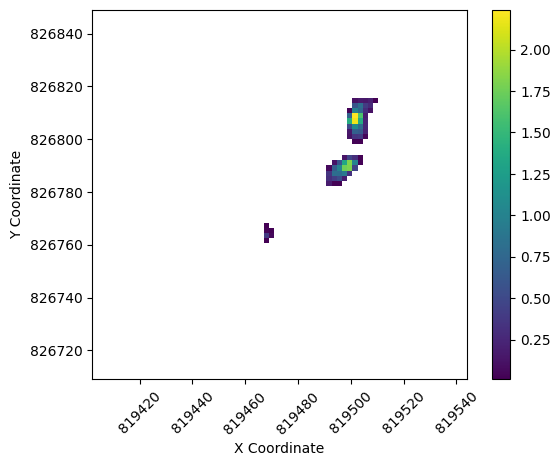

Plotting State 46


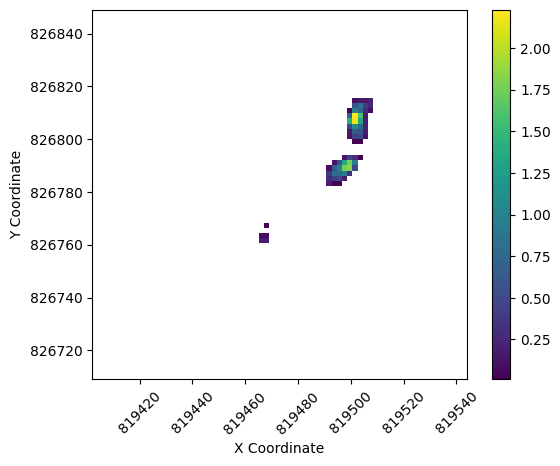

Plotting State 47


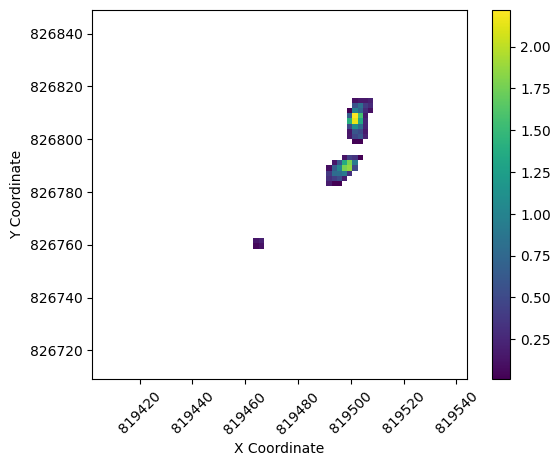

Plotting State 48


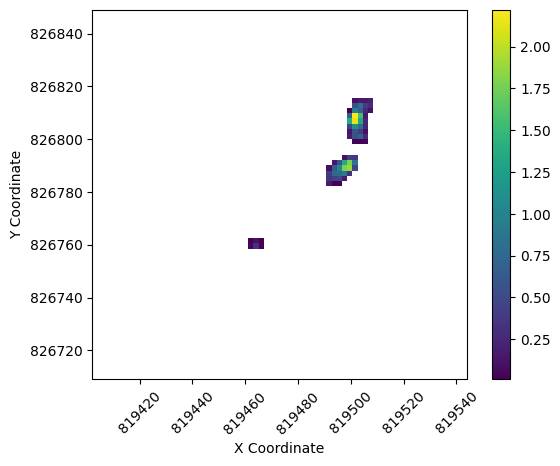

Plotting State 49


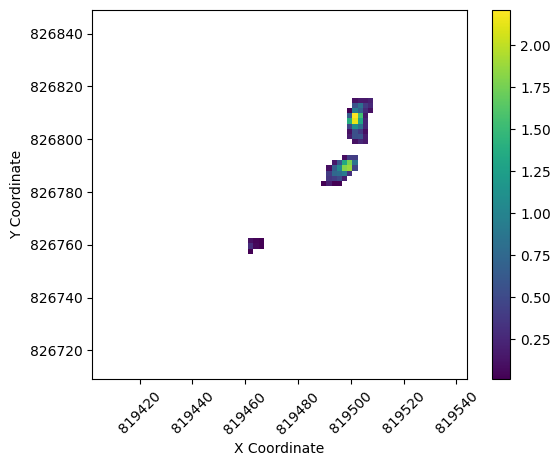

Plotting State 50


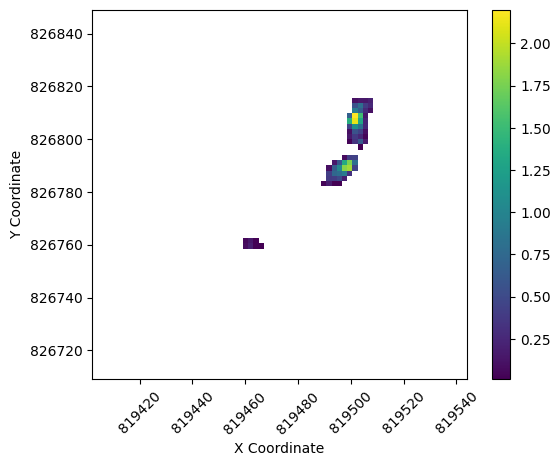

In [ ]:
plot_state_arrays_range(state_arrays, x_coords, y_coords, 40, 50, colormap='viridis', show_coords=True)

In [ ]:
state_arrays, x_coords, y_coords = dataframe_to_state_arrays(solids_vels_df, x_col='Solid_X', y_col='Solid_Y')


Plotting State 40


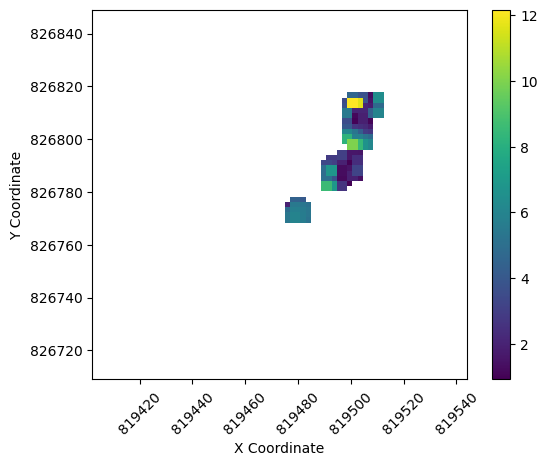

Plotting State 41


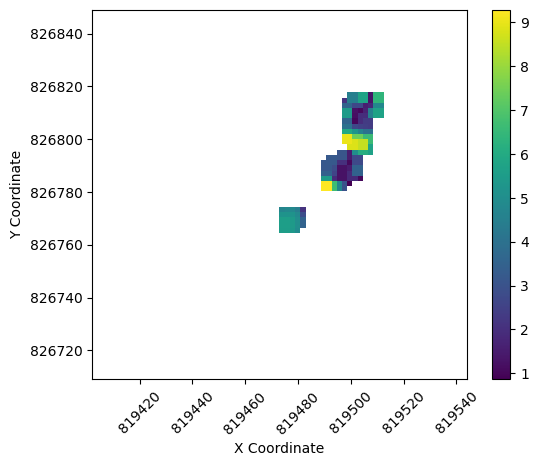

Plotting State 42


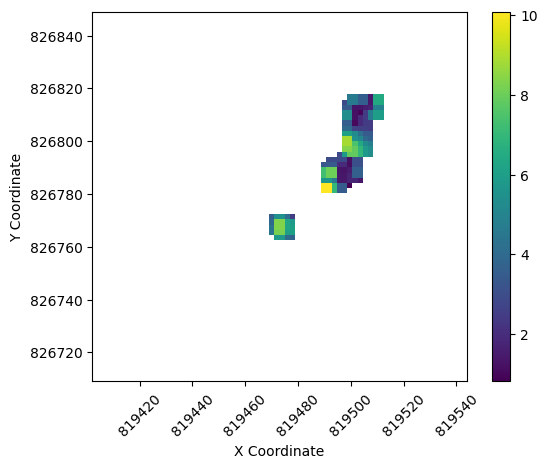

Plotting State 43


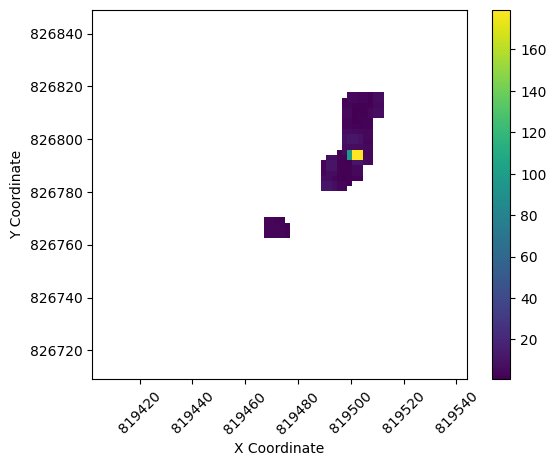

Plotting State 44


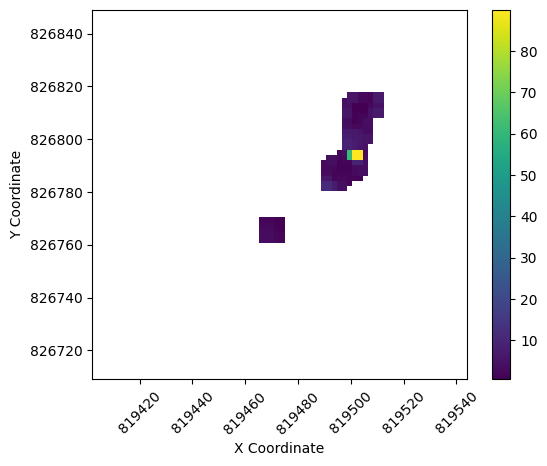

Plotting State 45


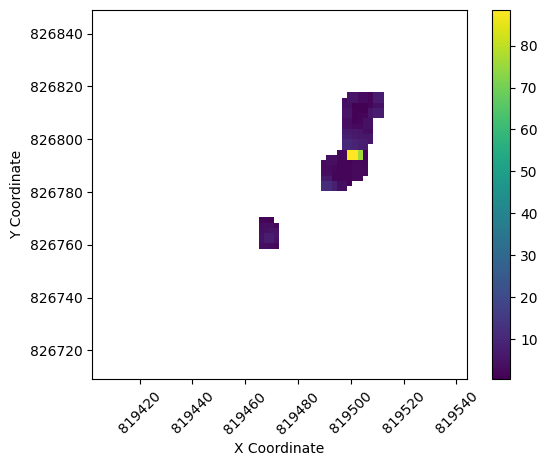

Plotting State 46


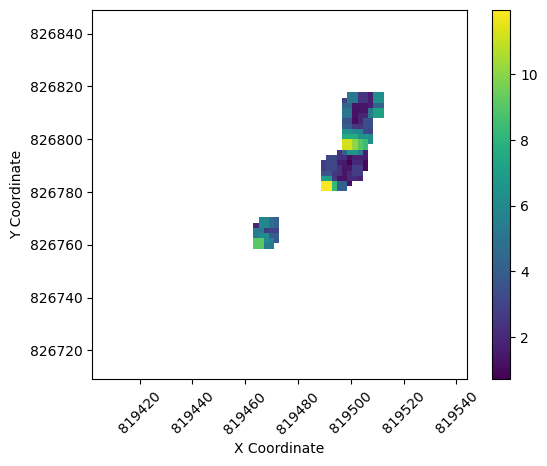

Plotting State 47


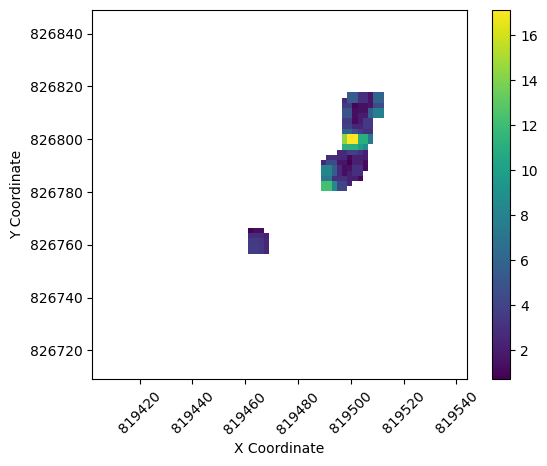

Plotting State 48


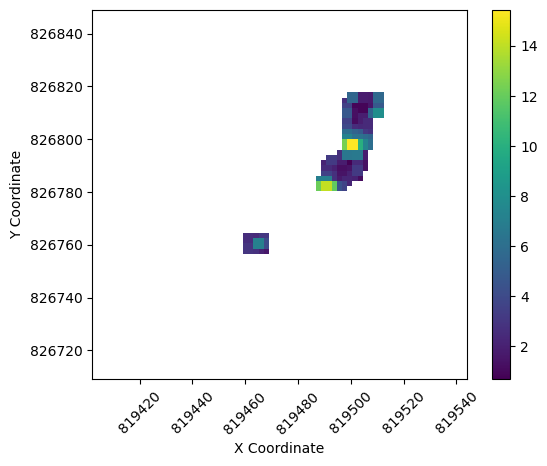

Plotting State 49


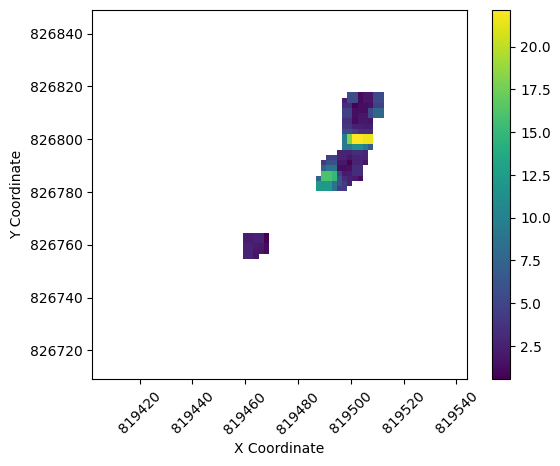

Plotting State 50


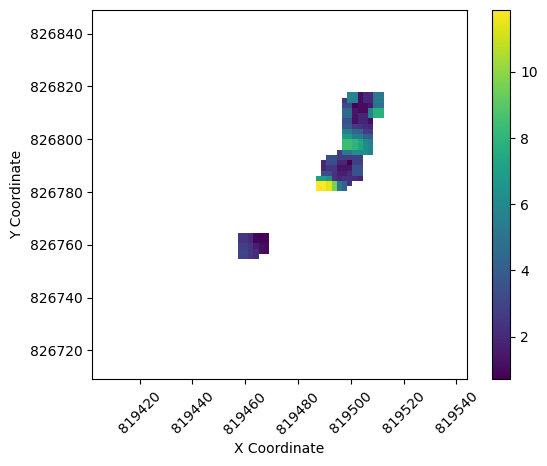

In [ ]:
plot_state_arrays_range(state_arrays, x_coords, y_coords, 40, 50, colormap='viridis', show_coords=True)

In [ ]:
max = flatten_to_max_value(state_arrays)

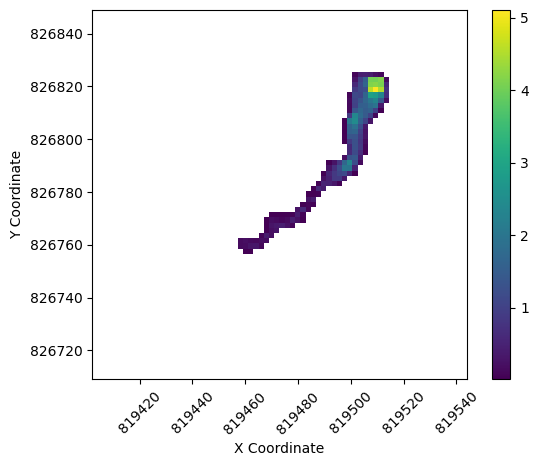

In [ ]:
plot_array_as_raster(max, x_coords, y_coords)

In [ ]:
topo_shells_df

,Shell_Label,Shell_X,Shell_Y,Shell_Z,Group_ID
0,1,819352.0,826661.0,52.2150,819352.0_826661.0
1,2,819354.0,826661.0,53.1025,819354.0_826661.0
2,3,819356.0,826661.0,54.0125,819356.0_826661.0
3,4,819358.0,826661.0,54.7050,819358.0_826661.0
4,5,819360.0,826661.0,55.1275,819360.0_826661.0
...,...,...,...,...,...
14394,14395,819584.0,826897.0,51.1700,819584.0_826897.0
14395,14396,819586.0,826897.0,52.9700,819586.0_826897.0
14396,14397,819588.0,826897.0,54.6525,819588.0_826897.0
14397,14398,819590.0,826897.0,56.0800,819590.0_826897.0


In [ ]:
topo_array, x_coords, y_coords = dataframe_to_elevation_array(topo_shells_df, x_col='Shell_X', y_col='Shell_Y',z_col='Shell_Z')

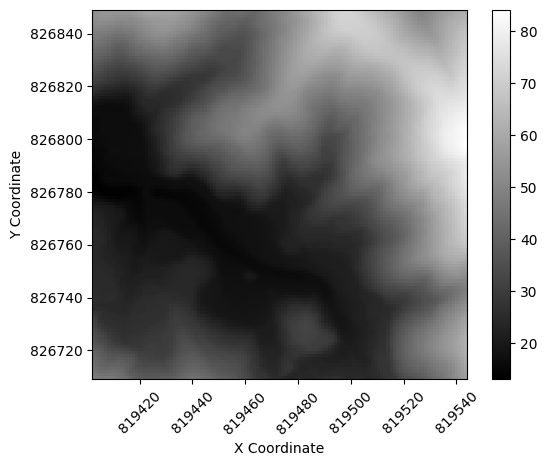

In [ ]:
plot_array_as_raster(topo_array, x_coords, y_coords, colormap='gray', blank_zeros=False)

In [ ]:
solids_vels_df

,Group_ID,Solid_X,Solid_Y,State_1,State_2,State_3,State_4,State_5,State_6,State_7,...,State_110,State_111,State_112,State_113,State_114,State_115,State_116,State_117,State_118,State_119
0,819402.0_826793.0,819402.0,826793.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,819402.0_826795.0,819402.0,826795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,819402.0_826797.0,819402.0,826797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,819402.0_826799.0,819402.0,826799.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,819402.0_826801.0,819402.0,826801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,819544.0_826747.0,819544.0,826747.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2970,819544.0_826749.0,819544.0,826749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2971,819544.0_826751.0,819544.0,826751.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2972,819544.0_826753.0,819544.0,826753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def check_group_id_uniqueness(df, group_id_col='Group_ID'):
    """
    Check if the values in the Group_ID column of the given DataFrame are unique.

    Args:
    df (pd.DataFrame): DataFrame to check for uniqueness of Group_ID.
    group_id_col (str): Column name for the group ID.

    Returns:
    bool: True if the Group_ID values are unique, False otherwise.
    """
    return df[group_id_col].is_unique

# Usage example:
# is_unique = check_group_id_uniqueness(topo_shells_df)

In [ ]:
check_group_id_uniqueness(topo_shells_df)

True

In [ ]:
def get_min_max_extents(df, x_col='X', y_col='Y'):
    """
    Calculate the minimum and maximum extents of the 'X' and 'Y' columns in a DataFrame.

    Args:
    df (pd.DataFrame): DataFrame with 'X' and 'Y' columns.
    x_col (str): Column name representing the 'X' coordinate.
    y_col (str): Column name representing the 'Y' coordinate.

    Returns:
    dict: Dictionary containing the min and max extents for 'X' and 'Y'.
    """
    x_min = df[x_col].min()
    x_max = df[x_col].max()
    y_min = df[y_col].min()
    y_max = df[y_col].max()

    return {'X_min': x_min, 'X_max': x_max, 'Y_min': y_min, 'Y_max': y_max}



In [ ]:
extents_results = get_min_max_extents(solids_vels_df, x_col='Solid_X', y_col='Solid_Y')

extents_results

{'X_min': 819402.0, 'X_max': 819544.0, 'Y_min': 826709.0, 'Y_max': 826849.0}

In [ ]:
extents_topo = get_min_max_extents(topo_shells_df, x_col='Shell_X', y_col='Shell_Y')
extents_topo

{'X_min': 819352.0, 'X_max': 819592.0, 'Y_min': 826661.0, 'Y_max': 826897.0}

In [ ]:
extents_padded_results = get_min_max_extents(solids_thick_df, x_col='Solid_X', y_col='Solid_Y')
extents_padded_results

{'X_min': 819402.0, 'X_max': 819544.0, 'Y_min': 826709.0, 'Y_max': 826849.0}

In [ ]:
# Record the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 40.61950469017029 seconds
